In [66]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


In [67]:
#Imports
import torch 
import torch.nn as nn
from torch.nn import functional as F 
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torchvision
from tqdm import tqdm, trange
import time



In [68]:
#Hyperparamters
seed = 1320
val_size = 0.2
batch_size = 128
torch.manual_seed(seed)
device = "cuda" if torch.cuda.is_available() else "cpu"

**Let's split the dataset to training and validation splits**

In [69]:
train = pd.read_csv("/kaggle/input/digit-recognizer/train.csv")
train, val = train_test_split(train, test_size = val_size)

# **Code preprocessing functions**

In [70]:
def normalize(df):
    return df / 255

def reshape_im(df):
    return df.values.reshape(-1, 28, 28, 1)

def to_tensor(df):
    df = np.float32(df)
    tensor = torch.tensor(df)
    return tensor

def transform(df):
    df = normalize(df)
    df = reshape_im(df)
    return to_tensor(df)

def transform_labels(label):
    return torch.tensor(label, dtype=torch.long)


# **Create a custom pytorch dataset**

In [71]:
class MyDataset(Dataset):
    def __init__(self, data, test = False):
        self.test = test
        if not test:
            self.image = transform(data.drop("label", axis=1))
            self.label = transform_labels(data["label"].to_numpy())
        else:
            self.image = transform(data)
            self.label = None
    def __len__(self):
        return len(self.image)
    def __getitem__(self, idx):
        if not self.test:
            im, label = self.image[idx], self.label[idx]
        else:
            im, label = self.image[idx], torch.tensor(0)
        return im, label
        

In [72]:
train_data = MyDataset(train)
val_data = MyDataset(val)

In [73]:
training_loader = DataLoader(train_data, batch_size = batch_size, shuffle = True)
val_loader = DataLoader(val_data, batch_size = batch_size, shuffle = True)

# Let's first code a simple Convolution model inspired from LeNet architecture 

In [74]:
class SimpleModel(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.layer1 = nn.Conv2d(in_channels, 6, 5) 
        self.layer2 = nn.Conv2d(6, 18, 3) # To calculate convout we use convout = (in_shape - num_filters + 1)*out_channels
        self.fc1  = nn.Linear(5 * 5 * 18,120)
        self.fc2 = nn.Linear(120, 30)
        self.fc3 = nn.Linear(30, 10)
        self.history = {}
        
    def forward(self, inputs):
        x = inputs.permute(0, 3, 1, 2) # N, H, W, C ----> N, C, H, W where
                                       #N:Batch_size, H, W : height and width, C:Channels
        x = self.layer1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.layer2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = x.reshape(-1, self.num_flat_features(x))
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.softmax(x, dim=1)

        return x
       
        
    def num_flat_features(self, x): # Calculates the dimention of the convolution's output (after max pool)
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
        

In [75]:
simpleModel =  SimpleModel(1)
simpleModel.to(device)

SimpleModel(
  (layer1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (layer2): Conv2d(6, 18, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=450, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=30, bias=True)
  (fc3): Linear(in_features=30, out_features=10, bias=True)
)

# Code the training function and a function to plot loss/accuracy per epoch evolution

In [76]:
phases = ["train", "val"]
loader_dict = {"train" : training_loader, "val" : val_loader}
dataset_dict = {"train" : train_data, "val" : val_data}
num_batch_dict = {"train" : len(train_data) // batch_size, "val" : len(val_data) // batch_size}

In [77]:
def plot_loss_acc(n_epochs, history):
    fig, axs = plt.subplots(2, 2, sharex = True)
    x_axis = np.linspace(1, n_epochs, num = n_epochs)
    axs[0, 0].plot(x_axis, history["train_loss"])
    axs[0, 0].set_title(f'train loss per epoch')
    axs[0, 1].plot(x_axis, history["train_acc"])
    axs[0, 1].set_title(f'train accuracy per epoch')
    axs[1, 0].plot(x_axis, history["val_loss"])
    axs[1, 0].set_title(f'validation loss per epoch')
    axs[1, 1].plot(x_axis, history["val_acc"])
    axs[1, 1].set_title(f'validation accuracy per epoch')
    plt.show()

In [78]:
def train(model, n_epochs, lr = 1e-2, optimizer = "Adam", plot = True):
    history = {
        "train_loss" : [],
        "train_acc" : [],
        "val_loss" : [],
        "val_acc" : []
    }
    running_loss = 0
    correct = 0
    loss_fn = torch.nn.CrossEntropyLoss()
    if optimizer == "Adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    else : 
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    model = model.to(device)
    for epoch in tqdm(range(n_epochs)):
        for phase in phases:
            if phase == "train":
                model.train()
            if phase == "val":
                model.eval()
            for i, data in enumerate(loader_dict[phase]):  
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
            
                optimizer.zero_grad()
                output = model(inputs)
                loss = loss_fn(output, labels)
                
                if phase == "train":
                    loss.backward()
                    optimizer.step()
                  
                running_loss += loss.item() * len(inputs)
                correct += (output.argmax(axis=1) == labels).sum()
               
        
                if (i+1) % num_batch_dict[phase] == 0:
                    avg_loss = running_loss / len(dataset_dict[phase])
                    acc = correct / len(dataset_dict[phase])
                    history[phase + "_loss"].append(avg_loss)
                    history[phase + "_acc"].append(acc.item())
                    running_loss = 0
                    correct = 0
    if plot:
        plot_loss_acc(n_epochs, history)
    return history



100%|██████████| 35/35 [00:56<00:00,  1.61s/it]


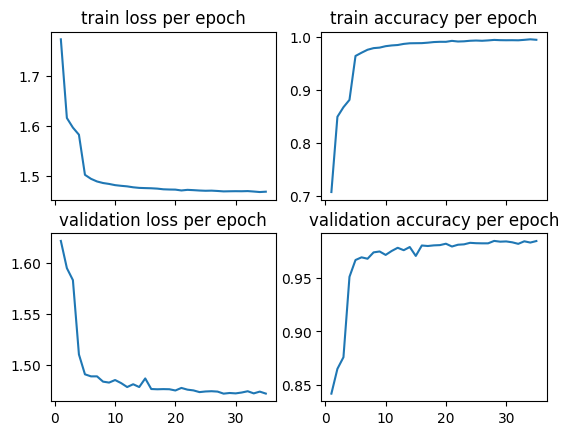

100%|██████████| 10/10 [00:14<00:00,  1.50s/it]


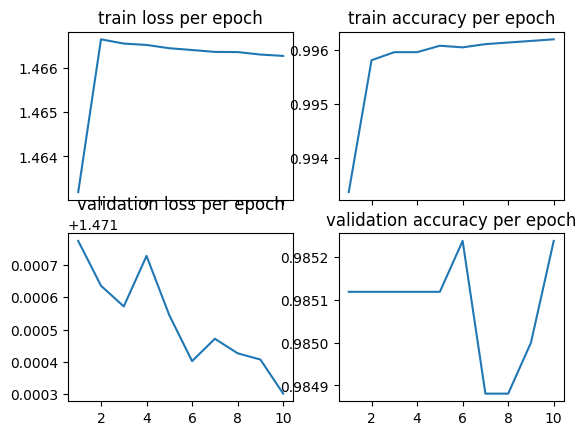

In [79]:
simpleModel =  SimpleModel(1)
history1 = train(simpleModel, 35, lr = 1e-3)
history2 = train(simpleModel, 10, lr=1e-3, optimizer="SGD") #Usse the SGD optim to furhter fine tune model params

In [80]:
test = pd.read_csv("/kaggle/input/digit-recognizer/test.csv")
test_data = MyDataset(test, test=True)
test_loader = DataLoader(test_data, batch_size = batch_size)

In [87]:
def predict(model):
    predictions = []
    model.eval()
    for i, data in enumerate(test_loader):
        inputs, _ = data
        inputs = inputs.to(device)
        with torch.no_grad():
            output = model(inputs)
            output = output.argmax(axis = 1)
            output = output.cpu().numpy()
        for out in output:
            predictions.append(out)
    return predictions
    

In [88]:
predictions = predict(simpleModel)

In [89]:
submission = pd.read_csv("/kaggle/input/digit-recognizer/sample_submission.csv")
submission.head()

,ImageId,Label
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [90]:
submission["Label"] = predictions
submission.to_csv('submission.csv', index=False)

In [91]:
class DeeperModel(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.layer1 = nn.Conv2d(in_channels, 24, 5) # Conv2d(num_of_input_channels, num_of_output_chan, kernel size)
        self.layer2 = nn.Conv2d(24, 18, 3)
        # To calculate convout we use convout = (in_shpae - numf_filters + 1)*out_channels, so im_size_out = ((28 - 5 + 1)/2 - 3 + 1)/2 = 5
        self.fc1  = nn.Linear(5 * 5 * 18,120)
        self.fc2 = nn.Linear(120, 180)
        self.fc3 = nn.Linear(180, 90)
        self.fc4 = nn.Linear(90, 40)
        self.fc5 = nn.Linear(40, 10)
        
        
    def forward(self, inputs):
        x = inputs.permute(0, 3, 1, 2) # N, H, W, C ----> N, C, H, W
        x = self.layer1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.layer2(x) 
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = x.reshape(-1, self.num_flat_features(x))
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x) + x
        x = self.fc4(x)
        x = F.relu(x) + x
        x = self.fc5(x) 
        x = F.softmax(x, dim=1)

        return x
       
        
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
        

In [92]:
Deepermodel = DeeperModel(1)
history = train(model, 30, lr=1e-3)
history2 = train(model, 10, lr=5e-3, optimizer="SGD")


  3%|▎         | 1/30 [00:03<01:34,  3.27s/it]


KeyboardInterrupt: 

In [ ]:
predictions = predict(Deepermodel)

In [ ]:
submission = pd.read_csv("/kaggle/input/digit-recognizer/sample_submission.csv")
submission["Label"] = predictions
#submission.to_csv('Deepersubmission.csv', index=False)